In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
import os

In [2]:
torch.manual_seed(99)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Resize(64), 
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.CIFAR10("./cifar10", download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)

Files already downloaded and verified


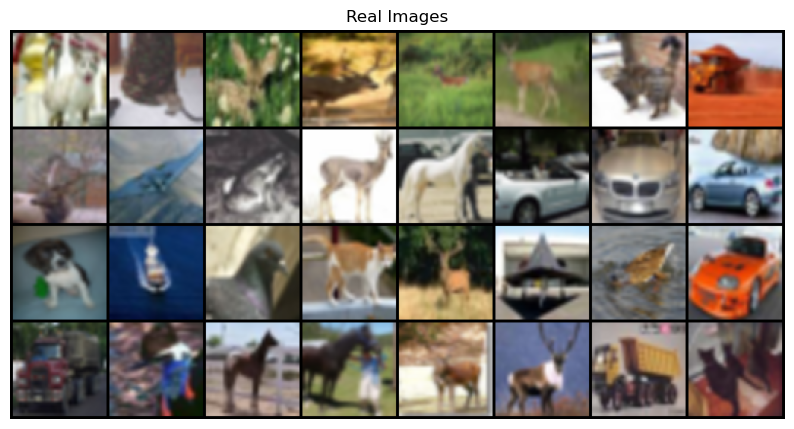

In [5]:
real_image_batch = next(iter(data_loader))
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_image_batch[0].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1024, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=512, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=2, padding=0),
        )

    def forward(self, x):
        return self.disc(x)
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)
            
generator = Generator().to(device)
discriminator = Discriminator().to(device)

initialize_weights(generator)
initialize_weights(discriminator)

if not os.path.exists('Results/WGAN_FAKE'):
    os.makedirs('Results/WGAN_FAKE')
if not os.path.exists('Results/WGAN_REAL'):
    os.makedirs('Results/WGAN_REAL')

In [7]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])
inception_model = inception_model.to(device)

/home/tpittal/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tpittal/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [9]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [10]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [11]:
def gradient_penalty(critic, real, fake, device):
    size, c, h, w = real.shape
    alpha = torch.rand((size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Get critic scores for interpolated images
    mixed_scores = critic(interpolated_images)

    # Calculate gradients of scores with respect to images
    gradients = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Flatten gradients and compute their norm
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_norm = gradients.norm(2, dim=1)

    # Calculate gradient penalty
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    
    return gradient_penalty

In [12]:
gen_loss_arr = []
disc_loss_arr = []
fake_image = []
real_image = []
FID_arr = []


CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
LAMBDA_GP = 10

from tqdm import tqdm

def train(generator, discriminator, dataloader, epochs):
    gen_optim = optim.RMSprop(generator.parameters(), lr=5e-4)
    disc_optim = optim.RMSprop(discriminator.parameters(), lr=5e-4)
    loss_func = nn.BCELoss()
    
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        print(f"Epoch [{epoch+1}/{epochs}]")
        
        batch_gen_loss = []
        batch_disc_loss = []
        real_images = None
        fake_images = None
        
        with tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]") as progress_bar:
            for i, real_images in enumerate(progress_bar):
                real_images = real_images[0].to(device)
                batch_size = real_images.size(0)
                
                # Train Discriminator
                for _ in range(CRITIC_ITERATIONS):
                    z = torch.randn(batch_size, 100, 1, 1).to(device)
                    fake_images = generator(z)
                    disc_real = discriminator(real_images).view(-1)
                    disc_fake = discriminator(fake_images).view(-1)
                    grad_penalty = gradient_penalty(discriminator, real_images, fake_images, device)
                    disc_loss = -(torch.mean(disc_real) - torch.mean(disc_fake)) + (grad_penalty * LAMBDA_GP)
                    disc_optim.zero_grad()
                    disc_loss.backward(retain_graph=True)
                    disc_optim.step()
                batch_disc_loss.append(disc_loss.item())

                # Train Generator
                gen_optim.zero_grad()
                disc_fake = discriminator(fake_images).view(-1)
                gen_loss = -torch.mean(disc_fake)
                gen_loss.backward()
                gen_optim.step()
                batch_gen_loss.append(gen_loss.item())

                # Update tqdm progress bar description
                progress_bar.set_postfix(
                    Discriminator_Loss=f"{disc_loss.item():.4f}",
                    Generator_Loss=f"{gen_loss.item():.4f}"
                )

        # Save generated and real images
        with torch.no_grad():
            fakeimg_grid = torchvision.utils.make_grid(fake_images.detach().cpu(), padding=2, normalize=True)
            real_images_grid = torchvision.utils.make_grid(real_images.detach().cpu(), padding=2, normalize=True)
            fake_image.append(fakeimg_grid)
            real_image.append(real_images_grid)
            utils.save_image(fakeimg_grid, f'./Results/WGAN_FAKE/WGAN_epoch_{epoch:03d}.png', normalize=True)
            utils.save_image(real_images_grid, f'./Results/WGAN_REAL/WGAN_epoch_{epoch:03d}.png', normalize=True)
        
        # Log epoch losses
        gen_loss_arr.append(np.mean(batch_gen_loss))
        disc_loss_arr.append(np.mean(batch_disc_loss))

        # Calculate FID
        fretchet_dist = calculate_fretchet(real_images, fake_images, inception_model)
        FID_arr.append(fretchet_dist)
        print(f"FID value at epoch {epoch+1}/{epochs}: {fretchet_dist:.4f}")

In [13]:
train(generator, discriminator, data_loader, 25)

Epoch [1/25]


Epoch [1/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.86it/s, Discriminator_Loss=-21.0204, Generator_Loss=27.8464] 


FID value at epoch 1/25: 338.3196
Epoch [2/25]


Epoch [2/25]: 100%|██████████| 1562/1562 [03:54<00:00,  6.66it/s, Discriminator_Loss=-14.7979, Generator_Loss=-38.0191]


FID value at epoch 2/25: 355.5160
Epoch [3/25]


Epoch [3/25]: 100%|██████████| 1562/1562 [04:28<00:00,  5.82it/s, Discriminator_Loss=-13.0201, Generator_Loss=-9.1906] 


FID value at epoch 3/25: 325.4949
Epoch [4/25]


Epoch [4/25]: 100%|██████████| 1562/1562 [04:25<00:00,  5.88it/s, Discriminator_Loss=-8.0425, Generator_Loss=6.1373]   


FID value at epoch 4/25: 309.1328
Epoch [5/25]


Epoch [5/25]: 100%|██████████| 1562/1562 [04:27<00:00,  5.85it/s, Discriminator_Loss=-13.7783, Generator_Loss=7.3213]  


FID value at epoch 5/25: 317.9340
Epoch [6/25]


Epoch [6/25]: 100%|██████████| 1562/1562 [04:26<00:00,  5.86it/s, Discriminator_Loss=-11.2473, Generator_Loss=-20.4815]


FID value at epoch 6/25: 317.8854
Epoch [7/25]


Epoch [7/25]: 100%|██████████| 1562/1562 [04:28<00:00,  5.82it/s, Discriminator_Loss=-10.8894, Generator_Loss=-26.2506]


FID value at epoch 7/25: 293.0868
Epoch [8/25]


Epoch [8/25]: 100%|██████████| 1562/1562 [04:27<00:00,  5.84it/s, Discriminator_Loss=-13.5125, Generator_Loss=-15.6718]


FID value at epoch 8/25: 331.6301
Epoch [9/25]


Epoch [9/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.86it/s, Discriminator_Loss=-9.8570, Generator_Loss=11.9011]  


FID value at epoch 9/25: 283.3777
Epoch [10/25]


Epoch [10/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.87it/s, Discriminator_Loss=-9.7994, Generator_Loss=-41.7549] 


FID value at epoch 10/25: 305.3287
Epoch [11/25]


Epoch [11/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.86it/s, Discriminator_Loss=-12.3303, Generator_Loss=-31.0332]


FID value at epoch 11/25: 297.9906
Epoch [12/25]


Epoch [12/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.85it/s, Discriminator_Loss=-7.3954, Generator_Loss=-35.0719] 


FID value at epoch 12/25: 287.6278
Epoch [13/25]


Epoch [13/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.86it/s, Discriminator_Loss=-7.5583, Generator_Loss=-44.9318] 


FID value at epoch 13/25: 275.1973
Epoch [14/25]


Epoch [14/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.88it/s, Discriminator_Loss=-13.3674, Generator_Loss=-40.0651]


FID value at epoch 14/25: 283.6282
Epoch [15/25]


Epoch [15/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.85it/s, Discriminator_Loss=-9.3650, Generator_Loss=-36.1783] 


FID value at epoch 15/25: 270.2840
Epoch [16/25]


Epoch [16/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.85it/s, Discriminator_Loss=-3.8168, Generator_Loss=-41.8990] 


FID value at epoch 16/25: 275.6769
Epoch [17/25]


Epoch [17/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.85it/s, Discriminator_Loss=-6.8757, Generator_Loss=-50.3211] 


FID value at epoch 17/25: 264.8525
Epoch [18/25]


Epoch [18/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.87it/s, Discriminator_Loss=-9.4983, Generator_Loss=-45.8184] 


FID value at epoch 18/25: 285.7966
Epoch [19/25]


Epoch [19/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.87it/s, Discriminator_Loss=-7.0278, Generator_Loss=-20.4712] 


FID value at epoch 19/25: 266.5728
Epoch [20/25]


Epoch [20/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.85it/s, Discriminator_Loss=-7.2641, Generator_Loss=-33.7731] 


FID value at epoch 20/25: 268.6824
Epoch [21/25]


Epoch [21/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.85it/s, Discriminator_Loss=-8.9850, Generator_Loss=-19.3958] 


FID value at epoch 21/25: 272.7949
Epoch [22/25]


Epoch [22/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.85it/s, Discriminator_Loss=-10.0962, Generator_Loss=-4.5638] 


FID value at epoch 22/25: 268.9755
Epoch [23/25]


Epoch [23/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.86it/s, Discriminator_Loss=-7.7718, Generator_Loss=-8.4256]  


FID value at epoch 23/25: 275.8569
Epoch [24/25]


Epoch [24/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.85it/s, Discriminator_Loss=-11.2275, Generator_Loss=-9.2760] 


FID value at epoch 24/25: 287.6244
Epoch [25/25]


Epoch [25/25]: 100%|██████████| 1562/1562 [02:38<00:00,  9.88it/s, Discriminator_Loss=-3.2632, Generator_Loss=-30.1595] 


FID value at epoch 25/25: 264.6610


In [14]:
if not os.path.exists('Results/FID'):
       os.makedirs('Results/FID')
np.save('Results/WGAN_FID', FID_arr) 

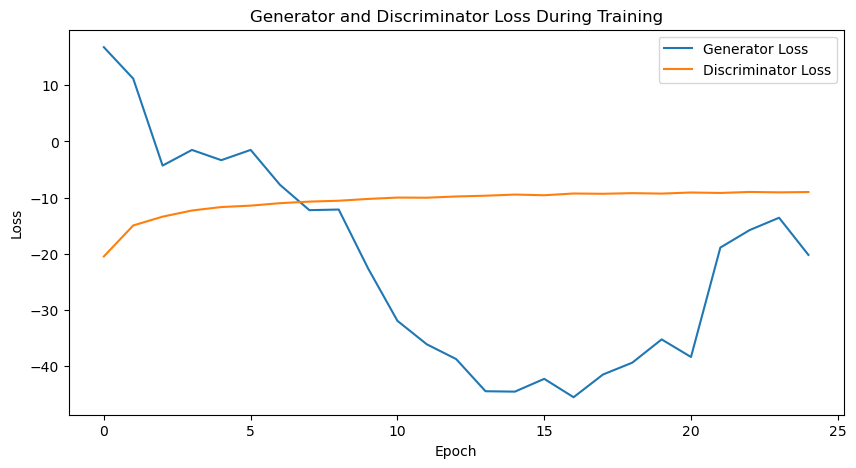

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_loss_arr, label="Generator Loss")
plt.plot(disc_loss_arr, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

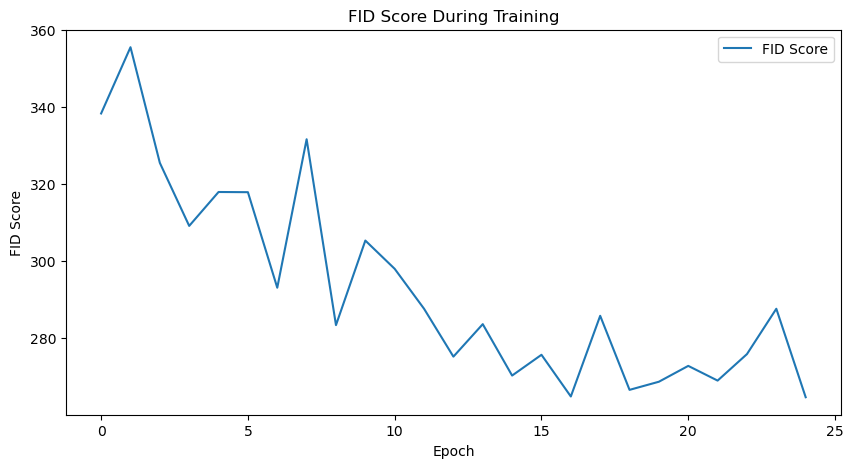

In [16]:
plt.figure(figsize=(10, 5))
plt.title("FID Score During Training")
plt.plot(FID_arr, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

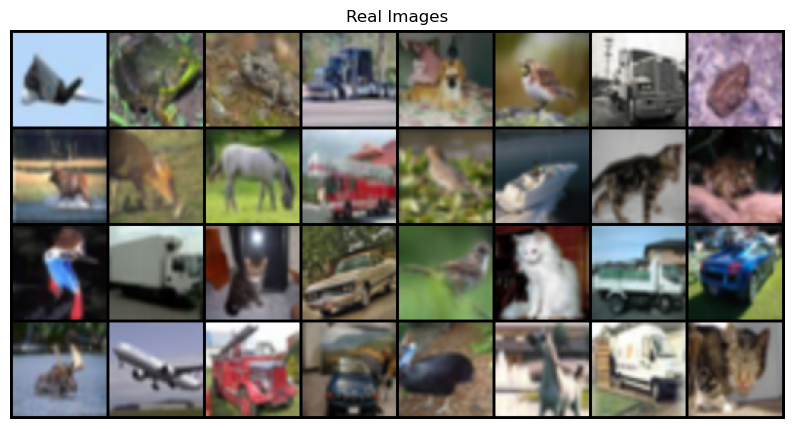

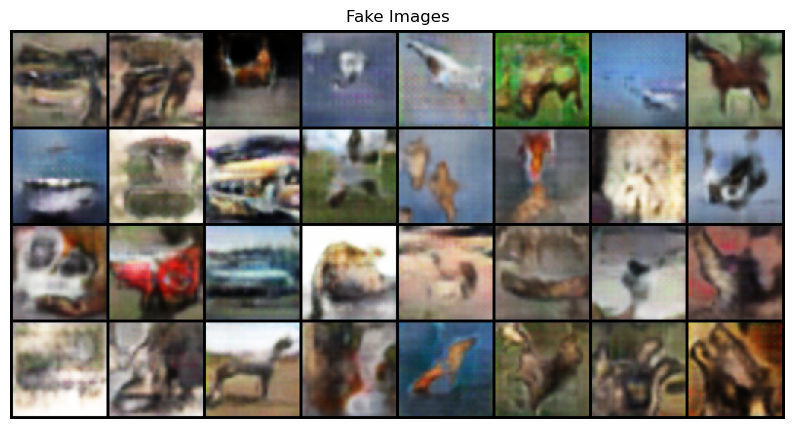

In [17]:
#real
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_image[-1], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()


# fake 
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(utils.make_grid(fake_image[-1], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()